In [1]:
DATASET_FOLDER = "./data" 
TRAIN_FILES = f"{DATASET_FOLDER}/train_masked.txt"
TEST_FILES =  f"{DATASET_FOLDER}/test_masked.txt"

In [2]:
import tensorflow as tf 
import os 
training_files = open(TRAIN_FILES,"r").readlines()
training_files = [os.path.join(DATASET_FOLDER,"data",f"{file.strip()}.jpg") for file in training_files]
t_data = tf.data.Dataset.list_files(training_files)

2024-10-16 22:35:23.380551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2024-10-16 22:35:23.380599: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-16 22:35:23.380636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c3619.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2024-10-16 22:35:23.384376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from PIL import Image
import numpy as np 


def read_npy_file(item):
    # print(item.numpy().decode())
    # item = tf.io.decode(item)
    data = np.load(item.numpy().decode())
    data = data['arr_0']
    data = data.max(axis=-1)# convert instance mask to semantic mask
    # print(data.shape)
    # data = np.squeeze(data,axis=1)
    return data



def load_data(file_path):
    mask_path = tf.strings.regex_replace(file_path,".jpg",".npz")
    
    image = tf.io.read_file(file_path)
    image = tf.io.decode_image(image)
    mask = tf.py_function(read_npy_file,[mask_path], [tf.float32,])
    # mask = tf.io.decode_raw(mask,tf.float16)
    return image, mask
    

In [4]:
training_data = t_data.map(load_data)

for image,mask in training_data.take(1):
    print(image.shape,mask.shape)

2024-10-16 22:35:23.586667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(1365, 2048, 3) (1, 1365, 2048)


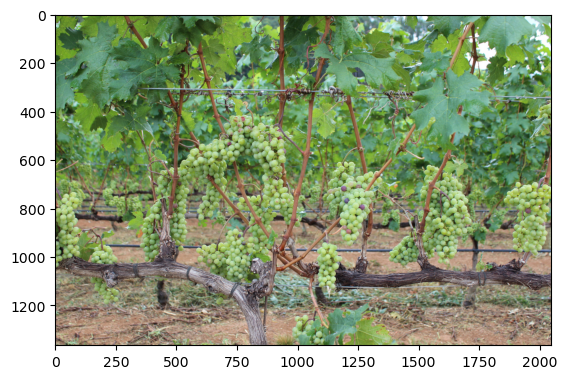

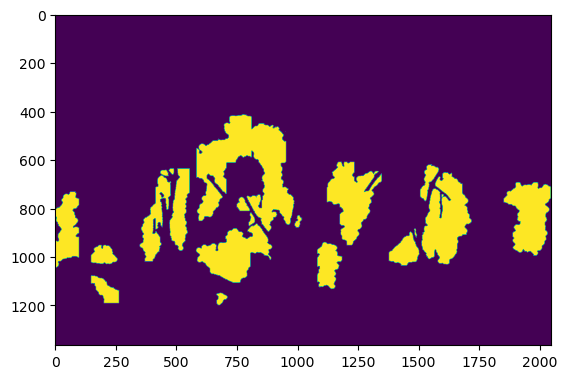

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()
plt.imshow(mask[0])
plt.show()

In [6]:
def generate_non_overlapping_grids(image,mask):
    # image,mask = item
    image_shape = tf.shape(image)
    img_height, img_width = image_shape[0], image_shape[1]
    
    # Calculate padding needed to make image and mask divisible by 200
    pad_height = 200 - img_height % 200 if img_height % 200 != 0 else 0
    pad_width = 200 - img_width % 200 if img_width % 200 != 0 else 0
    
    # Pad the image and mask
    image_padded = tf.image.pad_to_bounding_box(image, 0, 0, img_height + pad_height, img_width + pad_width)
    mask_padded = tf.image.pad_to_bounding_box(mask, 0, 0, img_height + pad_height, img_width + pad_width)
    
    # Calculate the number of 200x200 crops along height and width
    num_rows = (img_height + pad_height) // 200
    num_cols = (img_width + pad_width) // 200
    
    # Initialize lists to store the image and mask grids
    image_crops = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    mask_crops = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    crop_index = 0
    
    # Loop over the padded image and mask to extract 200x200 crops
    for i in range(num_rows):
        for j in range(num_cols):
            # Extract 200x200 crops from image and mask
            image_crop = image_padded[i * 200:(i + 1) * 200, j * 200:(j + 1) * 200, :]
            mask_crop = mask_padded[i * 200:(i + 1) * 200, j * 200:(j + 1) * 200, :]
            
            # Append crops to lists
            image_crops = image_crops.write(crop_index, image_crop)
            mask_crops = mask_crops.write(crop_index, mask_crop)
            crop_index += 1
    
    # Convert lists to TensorFlow datasets
    image_crops = image_crops.stack()
    mask_crops = mask_crops.stack()
    
    # Convert to datasets and return the zipped dataset
    return tf.data.Dataset.from_tensor_slices((image_crops, mask_crops))

In [7]:
new_data = training_data.flat_map(lambda image,mask: generate_non_overlapping_grids(image,mask))

ERROR:tensorflow:Error: Input value Tensor("while/while/strided_slice:0", shape=(None, None, None), dtype=uint8) has dtype <dtype: 'uint8'>, but expected dtype <dtype: 'float32'>.  This leads to undefined behavior and will be an error in future versions of TensorFlow.  Traceback:
  File "/common/cse479/shared/envs/tensorflow-env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/common/cse479/shared/envs/tensorflow-env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start
    se

In [ ]:
for image,mask in new_data.take(1):
    print(image.shape,mask.shape)

2024-10-16 22:35:29.094038: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25231360000 exceeds 10% of free system memory.
